# Geostrophic adjustment in the hydrostatic Boussinesq equations

This example simulates a one-dimensional geostrophic adjustement problem
using the `ClimateMachine.Ocean` subcomponent to solve the hydrostatic
Boussinesq equations.

First we `ClimateMachine.init()`.

In [1]:
using ClimateMachine

ClimateMachine.init()

# Domain setup

We formulate our problem in a Cartesian domain 100 km in ``x, y`` and 400 m
deep, and discretized on a grid with 100 fourth-order elements in ``x``, and 1
fourth-order element in ``y, z``,

In [2]:
using ClimateMachine.Ocean.Domains

domain = RectangularDomain(
    Ne = (25, 1, 1),
    Np = 4,
    x = (0, 1e6),
    y = (0, 1e6),
    z = (-400, 0),
    periodicity = (false, true, false),
)

RectangularDomain{Float64}
    Np = 4, Ne = (x = 25, y = 1, z = 1)
    L = (x = 1.0e6, y = 1.0e6, z = 400.0)


# Physical parameters

We use a Coriolis parameter appropriate for mid-latitudes,

In [3]:
f = 1e-4 # s⁻¹, Coriolis parameter
nothing # hide

and Earth's gravitational acceleration,

In [4]:
using CLIMAParameters: AbstractEarthParameterSet, Planet
struct EarthParameters <: AbstractEarthParameterSet end

g = Planet.grav(EarthParameters()) # m s⁻²

9.81

# An unbalanced initial state

We use a Gaussian, partially-balanced initial condition with parameters

In [5]:
U = 0.1              # geostrophic velocity (m s⁻¹)
L = domain.L.x / 40  # Gaussian width (m)
a = f * U * L / g    # amplitude of the geostrophic surface displacement (m)
x₀ = domain.L.x / 4  # Gaussian origin (m, recall that x ∈ [0, Lx])

250000.0

and functional form

In [6]:
Gaussian(x, L) = exp(-x^2 / (2 * L^2))

# Geostrophic ``y``-velocity: f V = g ∂_x η
vᵍ(x, y, z) = -U * (x - x₀) / L * Gaussian(x - x₀, L)

# Geostrophic surface displacement
ηᵍ(x, y, z) = a * Gaussian(x - x₀, L)

ηᵍ (generic function with 1 method)

We double the initial surface displacement so that the surface is half-balanced,
half unbalanced,

In [7]:
ηⁱ(x, y, z) = 2 * ηᵍ(x, y, z)

ηⁱ (generic function with 1 method)

In summary,

In [8]:
using ClimateMachine.Ocean.OceanProblems: InitialConditions

initial_conditions = InitialConditions(v = vᵍ, η = ηⁱ)

@info """ Parameters for the Geostrophic adjustment problem are...

    Coriolis parameter:                            $f s⁻¹
    Gravitational acceleration:                    $g m s⁻²
    Geostrophic velocity:                          $U m s⁻¹
    Width of the initial geostrophic perturbation: $L m
    Amplitude of the initial surface perturbation: $a m
    Rossby number (U / f L):                       $(U / (f * L))

"""

┌ Info:  Parameters for the Geostrophic adjustment problem are...
│ 
│     Coriolis parameter:                            0.0001 s⁻¹
│     Gravitational acceleration:                    9.81 m s⁻²
│     Geostrophic velocity:                          0.1 m s⁻¹
│     Width of the initial geostrophic perturbation: 25000.0 m
│     Amplitude of the initial surface perturbation: 0.0254841997961264 m
│     Rossby number (U / f L):                       0.04
│ 
└ @ Main.##351 string:5


# Boundary conditions, Driver configuration, and Solver configuration

Next, we configure the `HydrostaticBoussinesqModel` and build the `DriverConfiguration`.
We configure our model in a domain which is bounded in the ``x`` direction.
Both the boundary conditions in ``x`` and in ``z`` require boundary conditions,
which we define:

In [9]:
using ClimateMachine.Ocean:
    Impenetrable, Penetrable, FreeSlip, Insulating, OceanBC

solid_surface_boundary_conditions = OceanBC(
    Impenetrable(FreeSlip()), # Velocity boundary conditions
    Insulating(),             # Temperature boundary conditions
)

free_surface_boundary_conditions = OceanBC(
    Penetrable(FreeSlip()),   # Velocity boundary conditions
    Insulating(),             # Temperature boundary conditions
)

boundary_conditions =
    (solid_surface_boundary_conditions, free_surface_boundary_conditions)

(ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}(ClimateMachine.Ocean.Impenetrable{ClimateMachine.Ocean.FreeSlip}(ClimateMachine.Ocean.FreeSlip()), ClimateMachine.Ocean.Insulating()), ClimateMachine.Ocean.OceanBC{ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip},ClimateMachine.Ocean.Insulating}(ClimateMachine.Ocean.Penetrable{ClimateMachine.Ocean.FreeSlip}(ClimateMachine.Ocean.FreeSlip()), ClimateMachine.Ocean.Insulating()))

We refer to these boundary conditions by their indices in the `boundary_tags` tuple
when specifying the boundary conditions for the `state`; in other words, "1" corresponds to
`solid_surface_boundary_conditions`, while `2` corresponds to `free_surface_boundary_conditions`,

In [10]:
boundary_tags = (
    (1, 1), # (west, east) boundary conditions
    (0, 0), # (south, north) boundary conditions
    (1, 2), # (bottom, top) boundary conditions
)

((1, 1), (0, 0), (1, 2))

We're now ready to build the model.

In [11]:
using ClimateMachine.Ocean

model = Ocean.HydrostaticBoussinesqSuperModel(
    domain = domain,
    time_step = 2.0,
    initial_conditions = initial_conditions,
    parameters = EarthParameters(),
    turbulence_closure = (νʰ = 0, κʰ = 0, νᶻ = 0, κᶻ = 0),
    coriolis = (f₀ = f, β = 0),
    boundary_tags = boundary_tags,
    boundary_conditions = boundary_conditions,
)

┌ Info: Initializing 
└ @ ClimateMachine /central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/src/Driver/solver_configs.jl:167


ClimateMachine.Ocean.SuperModels.HydrostaticBoussinesqSuperModel{ClimateMachine.Ocean.Domains.RectangularDomain{Float64},ClimateMachine.Mesh.Grids.DiscontinuousSpectralElementGrid{Float64,3,(4, 4, 4),125,Array,Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}},Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}},Array{Float64,3},Array{Float64,4},Array{Int64,1},Array{Int64,2},Array{Int64,3},ClimateMachine.Mesh.Topologies.StackedBrickTopology{3,Float64,2},Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}},ClimateMachine.Mesh.Grids.MinNodalDistance{Float64}},ClimateMachine.Ocean.HydrostaticBoussinesq.HydrostaticBoussinesqModel{ClimateMachine.Ocean.Uncoupled,Main.##351.EarthParameters,ClimateMachine.Ocean.OceanProblems.InitialValueProblem{Float64,ClimateMachine.Ocean.OceanProblems.InitialConditions{typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##351.vᵍ),typeof(ClimateMachine.Ocean.OceanProblems.resting),typeof(Main.##351.ηⁱ)},Tuple{ClimateMachine.Ocean.O

!!! info "Horizontallly-periodic boundary conditions"
    To set horizontally-periodic boundary conditions with
    `(solid_surface_boundary_conditions, free_surface_boundary_conditions)`
    in the vertical direction use `periodicity = (true, true, false)` in
    the `domain` constructor and `boundary_tags = ((0, 0), (0, 0), (1, 2))`
    in the constructor for `HydrostaticBoussinesqSuperModel`.

# Animating the solution

To animate the `ClimateMachine.Ocean` solution, we'll create a callback
that draws a plot and stores it in an array. When the simulation is finished,
we'll string together the plotted frames into an animation.

In [12]:
using Printf
using Plots
using ClimateMachine.GenericCallbacks: EveryXSimulationSteps
using ClimateMachine.Ocean.Fields: assemble
using ClimateMachine.Ocean: current_step, current_time

u, v, η, θ = model.fields

# Container to hold the plotted frames
movie_plots = []

plot_every = 200 # iterations

plot_maker = EveryXSimulationSteps(plot_every) do

    @info "Steps: $(current_step(model)), time: $(current_time(model))"

    assembled_u = assemble(u.elements)
    assembled_v = assemble(v.elements)
    assembled_η = assemble(η.elements)

    umax = 0.5 * max(maximum(abs, u), maximum(abs, v))
    ulim = (-umax, umax)

    u_plot = plot(
        assembled_u.x[:, 1, 1],
        [assembled_u.data[:, 1, 1] assembled_v.data[:, 1, 1]],
        xlim = domain.x,
        ylim = (-0.7U, 0.7U),
        label = ["u" "v"],
        linewidth = 2,
        xlabel = "x (m)",
        ylabel = "Velocities (m s⁻¹)",
    )

    η_plot = plot(
        assembled_η.x[:, 1, 1],
        assembled_η.data[:, 1, 1],
        xlim = domain.x,
        ylim = (-0.01a, 1.2a),
        linewidth = 2,
        label = nothing,
        xlabel = "x (m)",
        ylabel = "η (m)",
    )

    push!(movie_plots, (u = u_plot, η = η_plot, time = current_time(model)))

    return nothing
end

ClimateMachine.GenericCallbacks.EveryXSimulationSteps(Main.##351.var"#1#2"(), 200, 0)

# Running the simulation and animating the results

Finally, we run the simulation,

In [13]:
hours = 3600.0

model.solver_configuration.timeend = 2hours

result = ClimateMachine.invoke!(
    model.solver_configuration;
    user_callbacks = [plot_maker],
)

┌ Info: Starting 
│     dt              = 2.00000e+00
│     timeend         =  7200.00
│     number of steps = 1
│     norm(Q)         = 3.6697037949282298e+05
└ @ ClimateMachine /central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/src/Driver/Driver.jl:763
┌ Info: Steps: 200, time: 400.0
└ @ Main.##351 string:16
┌ Info: Steps: 400, time: 800.0
└ @ Main.##351 string:16
┌ Info: Steps: 600, time: 1200.0
└ @ Main.##351 string:16
┌ Info: Steps: 800, time: 1600.0
└ @ Main.##351 string:16
┌ Info: Steps: 1000, time: 2000.0
└ @ Main.##351 string:16
┌ Info: Steps: 1200, time: 2400.0
└ @ Main.##351 string:16
┌ Info: Update
│     simtime =  2458.00 /  7200.00
│     wallclock = 00:01:00
│     efficiency (simtime / wallclock) =  40.7716
│     wallclock end (estimated) = 00:02:56
│     norm(Q) = 3.2659867396326480e+05
└ @ ClimateMachine.Callbacks /central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/src/Driver/Callbacks/Callbacks.jl:75
┌ Info: Steps: 1400, time: 2800.0


0.9092270436997197

and animate the results,

┌ Info: Saved animation to 
│   fn = /central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/docs/src/generated/Ocean/geostrophic_adjustment.gif
└ @ Plots /central/scratch/climaci/climatemachine-docs/892/depot/cpu/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/central/scratch/climaci/climatemachine-docs/892/climatemachine-docs/docs/src/generated/Ocean/geostrophic_adjustment.gif")
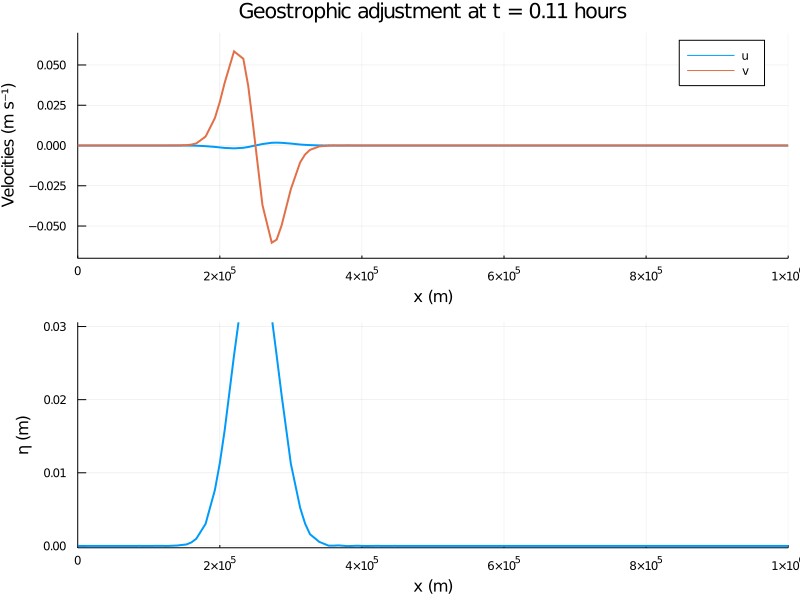

In [14]:
animation = @animate for p in movie_plots
    title = @sprintf("Geostrophic adjustment at t = %.2f hours", p.time / hours)
    frame = plot(
        p.u,
        p.η,
        layout = (2, 1),
        size = (800, 600),
        title = [title ""],
    )
end

gif(animation, "geostrophic_adjustment.gif", fps = 8) # hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*